# Import libraries and setup matplotlib

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('waveglow/')

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import pickle as pkl
import librosa
from text import *
import numpy as np
import torch
import hparams
from modules.model import Model
from denoiser import Denoiser

### Text preprocessing

In [2]:
from g2p_en import G2p
from text.symbols import symbols
from text.cleaners import custom_english_cleaners

# Mappings from symbol to numeric ID and vice versa:
symbol_to_id = {s: i for i, s in enumerate(symbols)}
id_to_symbol = {i: s for i, s in enumerate(symbols)}

g2p = G2p()
def text2seq(text, data_type='char'):
    text = custom_english_cleaners(text.rstrip())
    if data_type=='phone':
        clean_phone = []
        for s in g2p(text.lower()):
            if '@'+s in symbol_to_id:
                clean_phone.append('@'+s)
            else:
                clean_phone.append(s)
                text = clean_phone
    
    # Append SOS, EOS token
    sequence = [symbol_to_id[c] for c in text]
    sequence = [symbol_to_id['^']] + sequence + [symbol_to_id['~']]
    return sequence

### Waveglow

In [3]:
waveglow_path = 'training_log/waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']

for m in waveglow.modules():
    if 'Conv' in str(type(m)):
        setattr(m, 'padding_mode', 'zeros')

waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

with open('filelists/ljs_audio_text_val_filelist.txt', 'r') as f:
    lines = [line.split('|') for line in f.read().splitlines()]

phone_10000steps
Text: But though on the whole, except in Italy, Gothic letter was most often used
alpha: 0.8


alpha: 0.9


alpha: 1.0


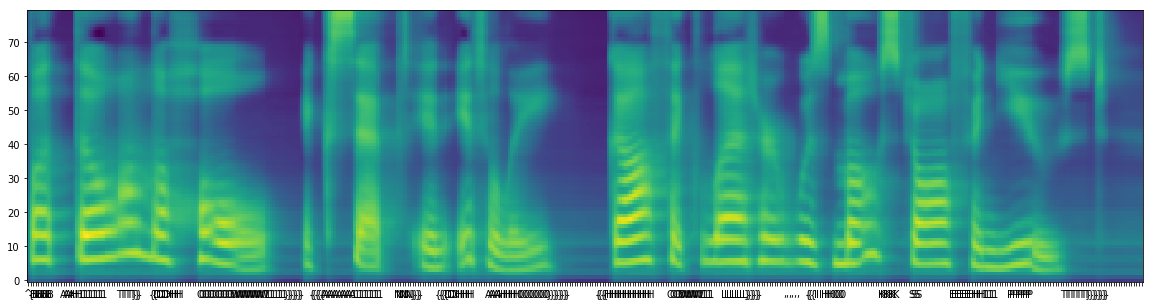

alpha: 1.1


alpha: 1.2


Text: It was reserved for the founders of the later eighteenth century to produce letters which are positively ugly, and which, it may be added,
alpha: 0.8


alpha: 0.9


alpha: 1.0


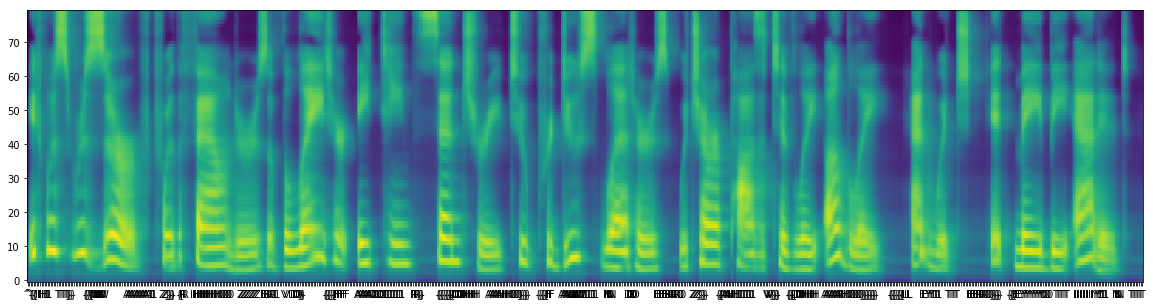

alpha: 1.1


alpha: 1.2


Text: in which latterly a copper had been fixed for the cooking of provisions sent in by charitable persons.
alpha: 0.8


alpha: 0.9


alpha: 1.0


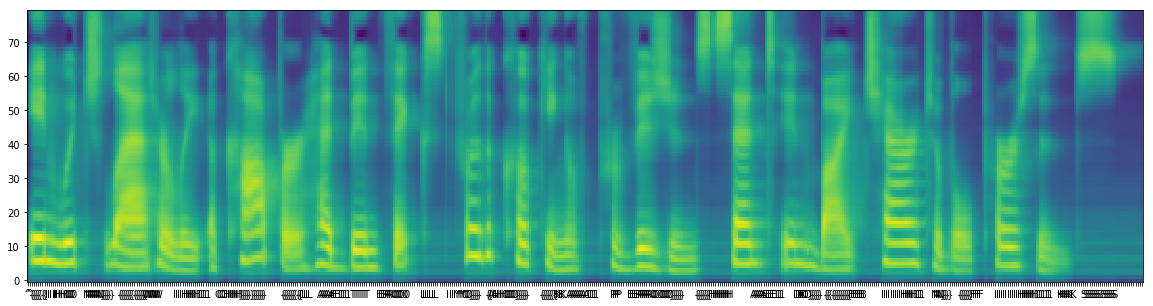

alpha: 1.1


alpha: 1.2


In [4]:
for data_type in ['phone']:
    for step in ['10000']:
        print(f'{data_type}_{step}steps')
        checkpoint_path = f"training_log/aligntts/stage3/checkpoint_{step}"
        state_dict = {}
        for k, v in torch.load(checkpoint_path)['state_dict'].items():
            state_dict[k[7:]]=v

        model = Model(hparams).cuda()
        model.load_state_dict(state_dict)
        _ = model.cuda().eval()

        for i in [1, 6, 22]:
            file_name, _, text = lines[i]
            sequence = np.array(text2seq(text, data_type))[None, :]
            sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()

            print(f'Text: {text}')
            for alpha in [0.8, 0.9, 1.0, 1.1, 1.2]:
                with torch.no_grad():
                    melspec, durations = model.inference(sequence, alpha)
                    audio = waveglow.infer(melspec, sigma=0.666)

                print(f"alpha: {alpha}")
                ipd.display(ipd.Audio(audio.cpu().numpy(), rate=hparams.sampling_rate))

                if alpha==1.0:
                    ticks=[]
                    phoneme = sequence_to_text(sequence[0].tolist())
                    for i, d in enumerate(durations[0]):
                        ticks.extend([phoneme[i]]*int(d))

                    plt.figure(figsize=(20,5))
                    plt.imshow(melspec.detach().cpu()[0], aspect='auto', origin='lower')
                    plt.xticks(range(melspec.size(2)), ticks)
                    plt.show()